# Djiba Kaba
### Immo Predictor — Valorisation et Diagnostic Intelligent
### Dataset : https://www.kaggle.com/datasets/lespin/house-prices-dataset/data

# Objectif :
- **Régression** : Estimer le prix d'un bien immobilier (`SalePrice`)
- **Classification** : Classifier automatiquement son type (`BldgType`)

## Étapes :
1. Analyse Exploratoire des Données (EDA)
2. Pré-traitement : gestion des valeurs manquantes, encodage, normalisation
3. Modélisation :
   - **Régression** : Decision Tree, Random Forest → MAE, RMSE, R²
   - **Classification** : SVM, Random Forest → Accuracy, F1-score, Matrice de confusion

---
## 0. Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, confusion_matrix, classification_report
)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')
print('Bibliothèques importées avec succès.')

Bibliothèques importées avec succès.


---
## 1. Chargement des données

In [2]:
df = pd.read_csv('train.csv')
print(f'Dimensions du dataset : {df.shape}')
print(f'Nombre de lignes     : {df.shape[0]}')
print(f'Nombre de colonnes   : {df.shape[1]}')
df.head()

Dimensions du dataset : (1460, 81)
Nombre de lignes     : 1460
Nombre de colonnes   : 81


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


> Le dataset Ames Housing contient **1 460 observations** et **81 variables** décrivant des biens immobiliers vendus à Ames, Iowa. Chaque ligne représente une maison avec ses caractéristiques physiques, sa localisation, sa qualité et son prix de vente. La richesse des variables (surface, qualité, année, quartier, équipements) offre un cadre idéal pour entraîner des modèles de régression et de classification.

---
## 2. Analyse Exploratoire des Données (EDA)

### 2.1 Types des colonnes et statistiques descriptives

In [3]:
print('=== Types de données ===')
print(df.dtypes.value_counts())
print(f'\nVariables numériques    : {df.select_dtypes(include=np.number).shape[1]}')
print(f'Variables catégorielles : {df.select_dtypes(include="object").shape[1]}')

=== Types de données ===
object     43
int64      35
float64     3
Name: count, dtype: int64

Variables numériques    : 38
Variables catégorielles : 43


> **Interprétation :** Le dataset est un mélange de **38 variables numériques** et **43 variables catégorielles**.

### 2.2 Valeurs manquantes

In [5]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'Nb NaN': missing, '% NaN': missing_pct})
print(f'Colonnes avec valeurs manquantes : {len(missing)}\n')
print(missing_df.to_string())

Colonnes avec valeurs manquantes : 19

              Nb NaN  % NaN
PoolQC          1453  99.52
MiscFeature     1406  96.30
Alley           1369  93.77
Fence           1179  80.75
MasVnrType       872  59.73
FireplaceQu      690  47.26
LotFrontage      259  17.74
GarageType        81   5.55
GarageYrBlt       81   5.55
GarageFinish      81   5.55
GarageQual        81   5.55
GarageCond        81   5.55
BsmtExposure      38   2.60
BsmtFinType2      38   2.60
BsmtQual          37   2.53
BsmtCond          37   2.53
BsmtFinType1      37   2.53
MasVnrArea         8   0.55
Electrical         1   0.07


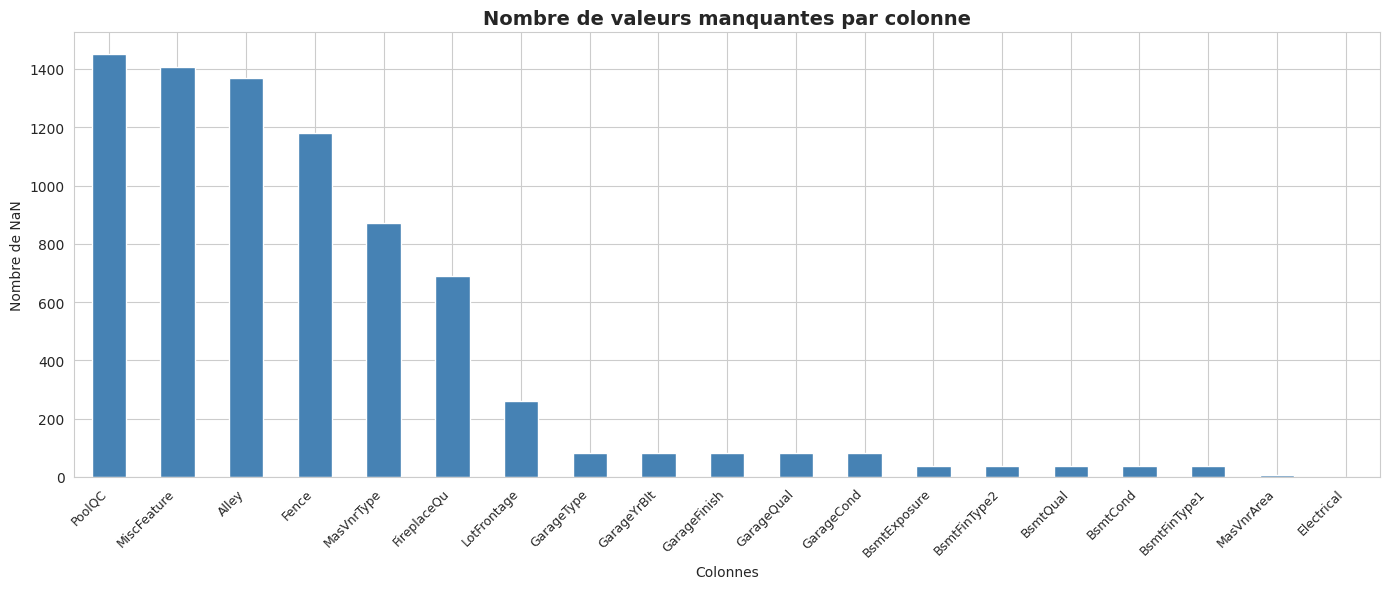

In [6]:
plt.figure(figsize=(14, 6))
missing.plot(kind='bar', color='steelblue', edgecolor='white')
plt.title('Nombre de valeurs manquantes par colonne', fontsize=14, fontweight='bold')
plt.xlabel('Colonnes')
plt.ylabel('Nombre de NaN')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.show()

> **Interprétation :** Le dataset compte **19 colonnes** contenant des valeurs manquantes. On distingue deux catégories :
>
> - **Manquants structurels (>80%)** : `PoolQC`, `MiscFeature`, `Alley`, `Fence` ont plus de 80% de NaN. Ces valeurs manquantes ne sont pas des erreurs — elles signifient simplement que le bien n'a pas la caractéristique (pas de piscine, pas d'accès à une ruelle, etc.). Ces colonnes ne font pas partie de nos features sélectionnées.
>
> - **Manquants partiels (<20%)** : `GarageType`, `GarageFinish`, `BsmtQual`, `TotalBsmtSF`, `GarageArea`, `GarageCars` ont un faible taux de NaN. Ces colonnes utilisées dans nos modèles seront traitées par **imputation médiane** (variables numériques) si la distribution est assymetrique et **imputation par la valeur la plus fréquente** (variables catégorielles).

### 2.3 Distribution de la variable cible — SalePrice

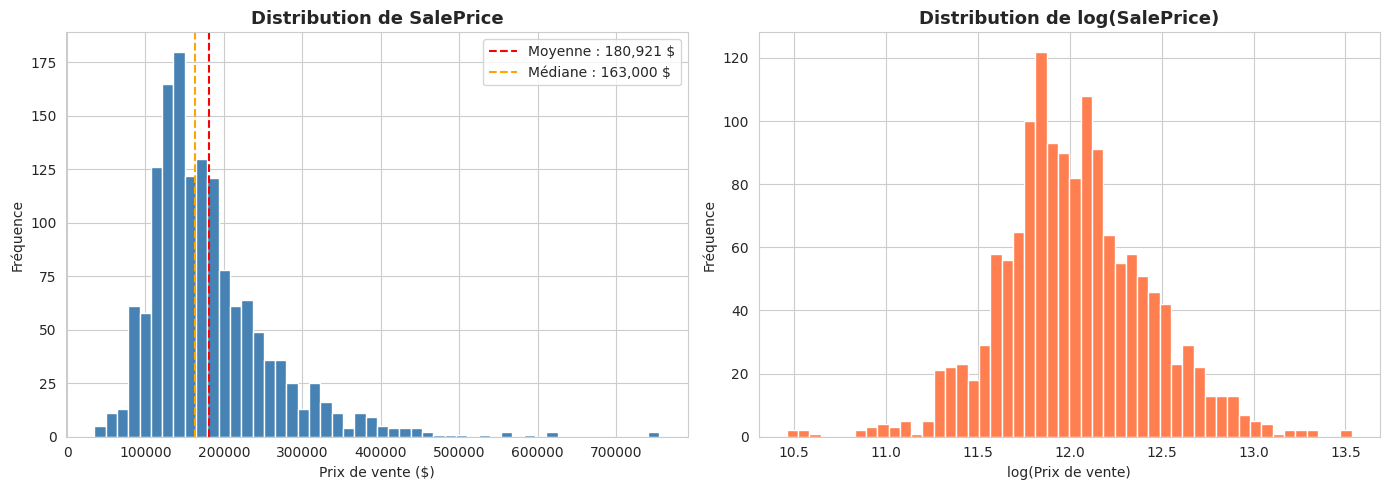

Moyenne   : 180,921 $
Médiane   : 163,000 $
Std       : 79,443 $
Min / Max : 34,900 $ / 755,000 $


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['SalePrice'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Distribution de SalePrice', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Prix de vente ($)')
axes[0].set_ylabel('Fréquence')
axes[0].axvline(df['SalePrice'].mean(), color='red', linestyle='--', label=f'Moyenne : {df["SalePrice"].mean():,.0f} $')
axes[0].axvline(df['SalePrice'].median(), color='orange', linestyle='--', label=f'Médiane : {df["SalePrice"].median():,.0f} $')
axes[0].legend()

axes[1].hist(np.log1p(df['SalePrice']), bins=50, color='coral', edgecolor='white')
axes[1].set_title('Distribution de log(SalePrice)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('log(Prix de vente)')
axes[1].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

print(f'Moyenne   : {df["SalePrice"].mean():,.0f} $')
print(f'Médiane   : {df["SalePrice"].median():,.0f} $')
print(f'Std       : {df["SalePrice"].std():,.0f} $')
print(f'Min / Max : {df["SalePrice"].min():,.0f} $ / {df["SalePrice"].max():,.0f} $')

> **Interprétation :** La distribution de `SalePrice` est **asymétrique à droite** (*right-skewed*) : la majorité des biens se vendent entre **100 000 $ et 250 000 $**, mais une queue longue vers la droite (quelques biens très chers) tire la moyenne (≈181 000 $) au-dessus de la médiane (≈163 000 $). Cela indique la présence de **valeurs extrêmes** (outliers) dans les prix élevés.
>
> Après transformation **logarithmique** (`log1p`), la distribution devient quasi-normale, ce qui serait bénéfique pour des modèles linéaires. Nos modèles à base d'arbres (Decision Tree, Random Forest) étant non paramétriques et insensibles à la forme de la distribution, nous conserverons la valeur originale de `SalePrice` comme cible.

### 2.4 Corrélations avec SalePrice

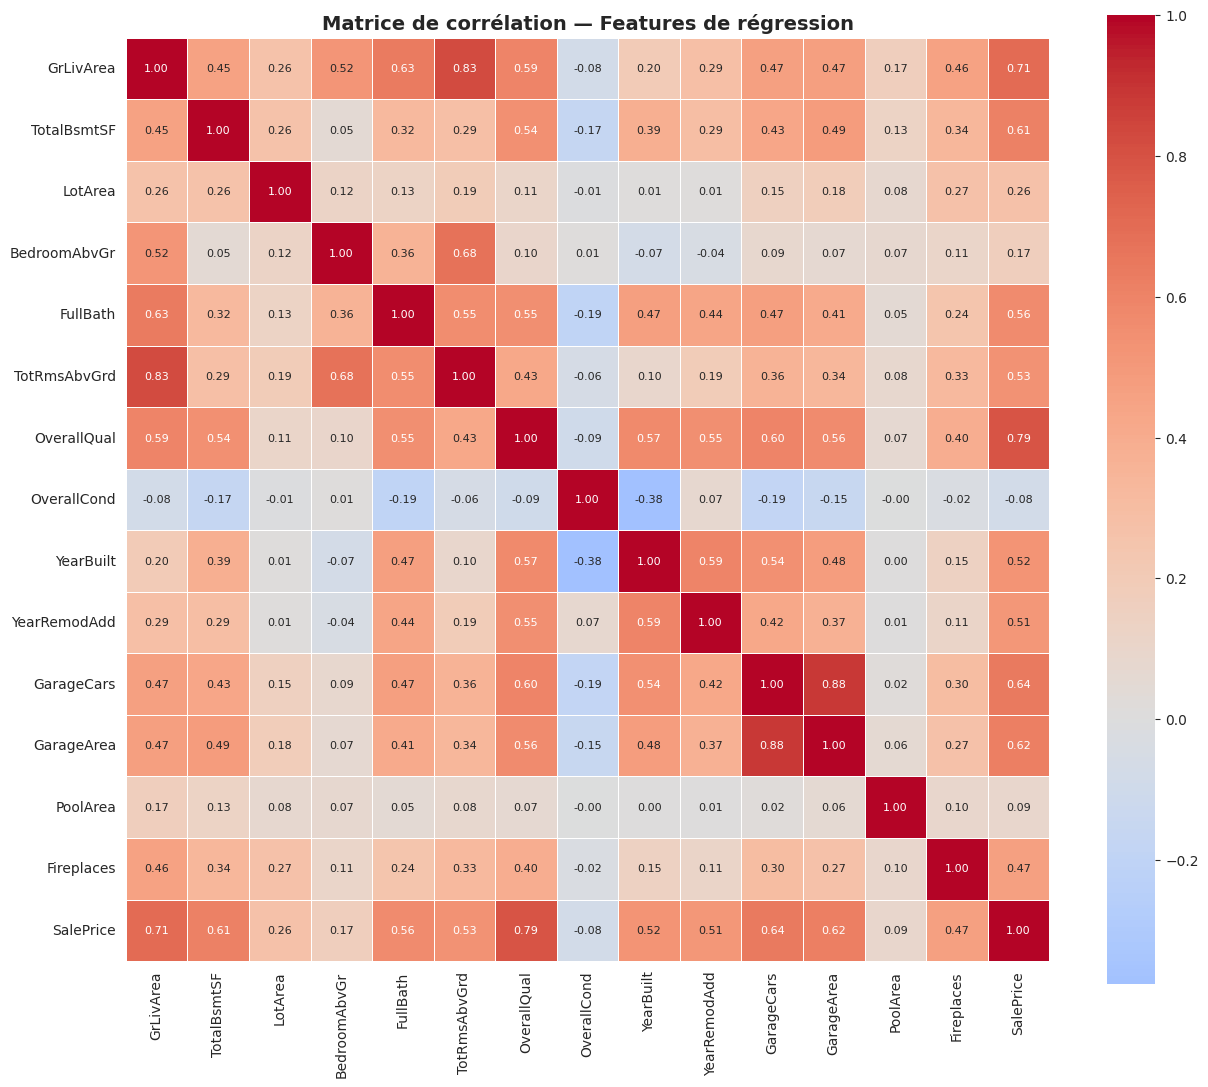

In [8]:
REG_FEATURES = [
    'GrLivArea', 'TotalBsmtSF', 'LotArea', 'BedroomAbvGr', 'FullBath',
    'TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'YearBuilt',
    'YearRemodAdd', 'GarageCars', 'GarageArea', 'PoolArea', 'Fireplaces'
]

corr_df = df[REG_FEATURES + ['SalePrice']].corr()

plt.figure(figsize=(13, 11))
sns.heatmap(
    corr_df, annot=True, fmt='.2f', cmap='coolwarm',
    center=0, linewidths=0.5, square=True,
    annot_kws={'size': 8}
)
plt.title('Matrice de corrélation — Features de régression', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

> **Interprétation :** La heatmap met en évidence plusieurs relations importantes :
>
> - **Corrélations fortes avec `SalePrice`** : `OverallQual` (r ≈ 0.79), `GrLivArea` (r ≈ 0.71), `GarageArea` (r ≈ 0.64), `GarageCars` (r ≈ 0.64). Ces variables sont les prédicteurs les plus puissants du prix.
> - **Corrélations modérées** : `YearBuilt`, `YearRemodAdd`, `TotalBsmtSF`, `FullBath`, `TotRmsAbvGrd`.
> - **Corrélations faibles** : `PoolArea` (r ≈ 0.09), `OverallCond` (r ≈ 0.09), `BedroomAbvGr` (r ≈ 0.17). Contre-intuitivement, le nombre de chambres est peu corrélé avec le prix — une maison peut avoir beaucoup de petites chambres et coûter moins cher.
> - **Multicolinéarité** : `GarageArea` et `GarageCars` sont fortement corrélées entre elles (r ≈ 0.88), de même que `YearBuilt` et `YearRemodAdd` (r ≈ 0.59). Cela ne pose pas de problème pour les arbres de décision, mais pourrait affecter des modèles linéaires.

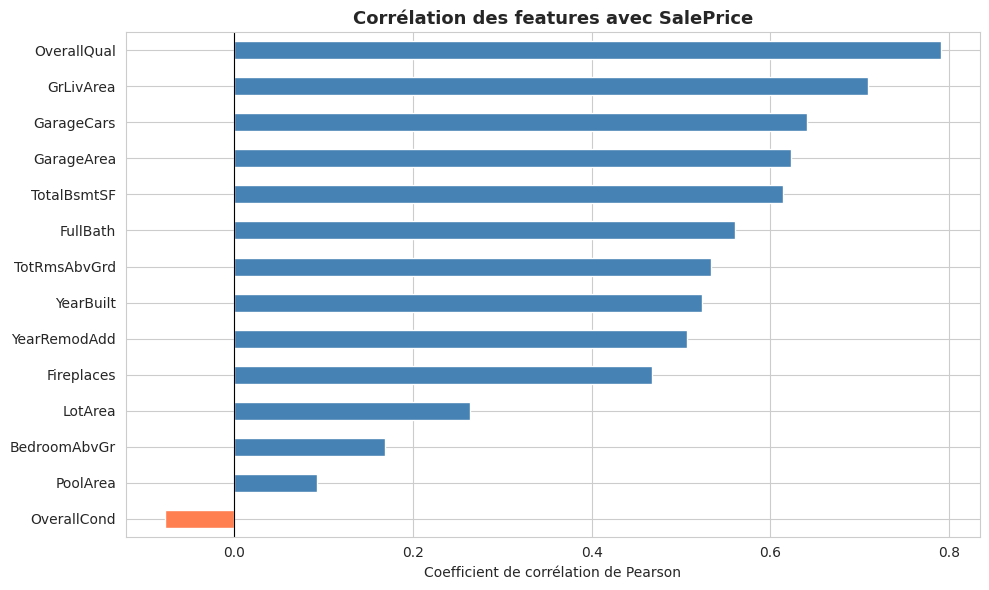

In [9]:
corr_target = corr_df['SalePrice'].drop('SalePrice').sort_values(ascending=True)

plt.figure(figsize=(10, 6))
colors = ['coral' if v < 0 else 'steelblue' for v in corr_target]
corr_target.plot(kind='barh', color=colors, edgecolor='white')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Corrélation des features avec SalePrice', fontsize=13, fontweight='bold')
plt.xlabel('Coefficient de corrélation de Pearson')
plt.tight_layout()
plt.show()

> **Interprétation :** Ce graphique confirme le classement des features par pertinence pour prédire `SalePrice`. `OverallQual` se détache nettement avec la corrélation la plus élevée (~0.79) : la qualité perçue d'une maison est le facteur le plus déterminant de son prix. Toutes les variables sélectionnées ont une corrélation positive — il n'y a aucune relation inversée significative. `PoolArea` et `BedroomAbvGr` contribuent le moins au modèle.

### 2.5 Nuages de points — Features numériques vs SalePrice

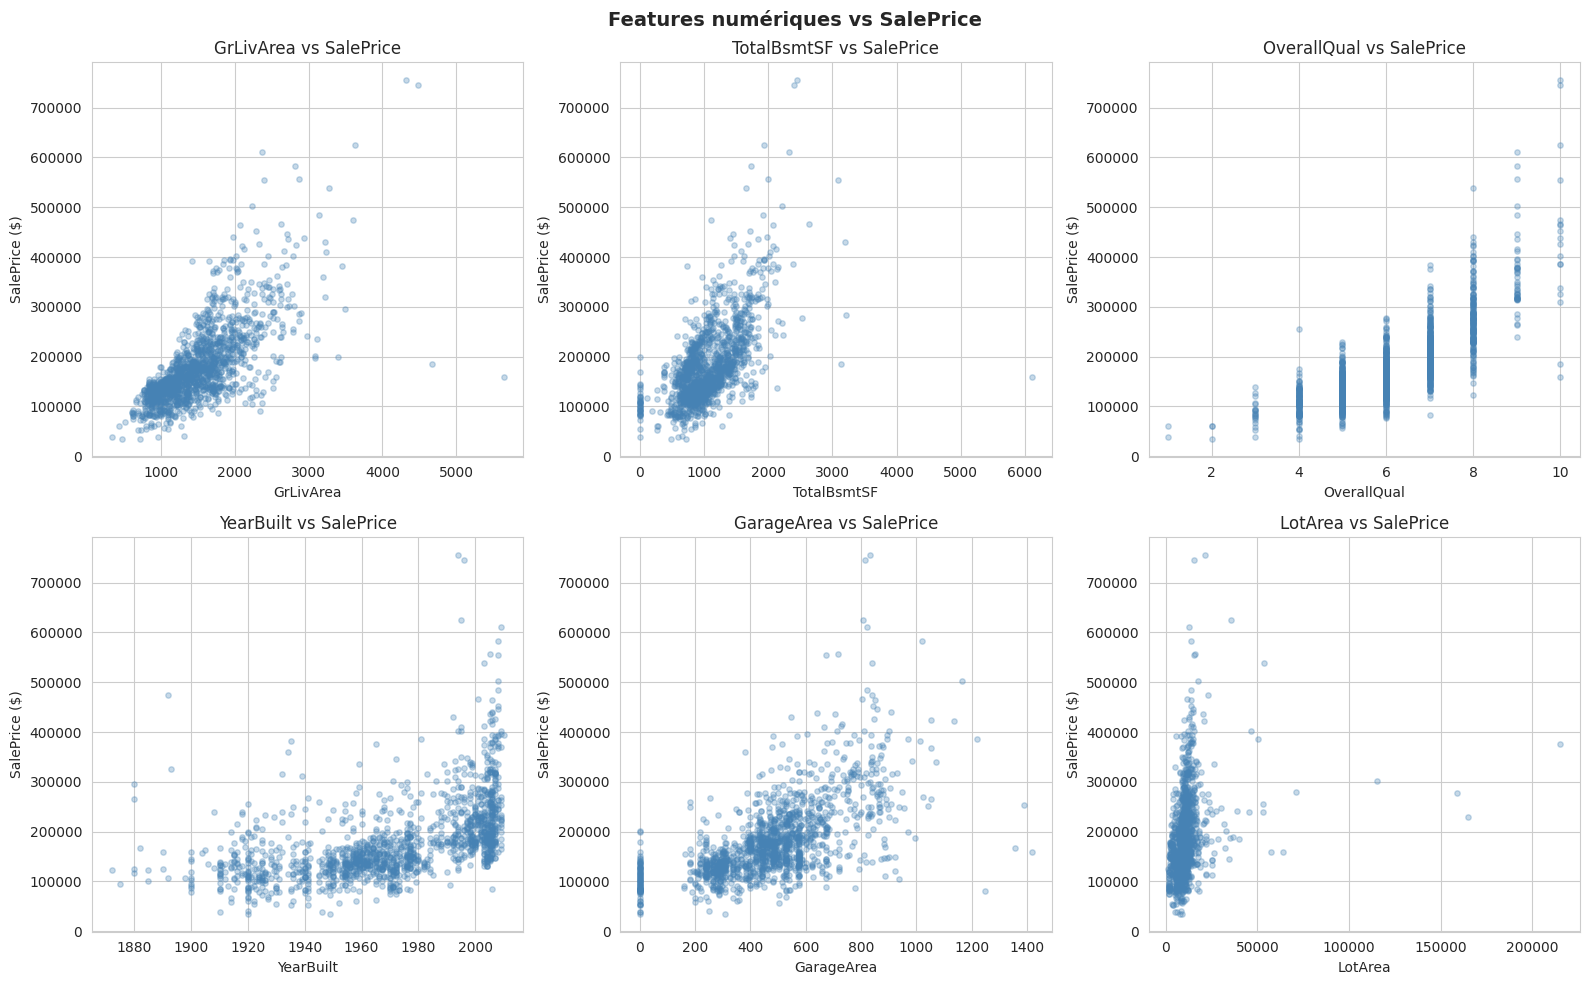

In [10]:
num_feats_plot = ['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'YearBuilt', 'GarageArea', 'LotArea']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for ax, feat in zip(axes.flatten(), num_feats_plot):
    ax.scatter(df[feat], df['SalePrice'], alpha=0.3, color='steelblue', s=15)
    ax.set_xlabel(feat)
    ax.set_ylabel('SalePrice ($)')
    ax.set_title(f'{feat} vs SalePrice')

plt.suptitle('Features numériques vs SalePrice', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

> **Interprétation :** Ces scatter plots permettent de visualiser la nature des relations entre les features et le prix :
>
> - **GrLivArea** : relation quasi-linéaire et positive. Deux outliers en bas à droite (très grande surface, prix anormalement bas) — probablement des ventes atypiques (saisies, enchères).
> - **TotalBsmtSF** : tendance positive claire. Les biens sans sous-sol (TotalBsmtSF = 0) forment un groupe à gauche avec des prix variés.
> - **OverallQual** : relation la plus nette — chaque palier de qualité (1 à 10) correspond à une plage de prix distinctement plus élevée. La dispersion croît avec la qualité, traduisant une plus grande variabilité pour les biens de luxe.
> - **YearBuilt** : les maisons récentes tendent à valoir plus cher, mais la relation est diffuse pour les constructions avant 1950, reflétant la diversité des marchés historiques.
> - **GarageArea** : tendance positive, avec un groupe de points à 0 (biens sans garage) qui maintiennent des prix relativement modérés.
> - **LotArea** : relation très faible et très dispersée. La superficie du terrain n'est pas un bon prédicteur linéaire du prix — quelques terrains immenses sont vendus à des prix étonnamment bas.

### 2.6 Distribution de BldgType (variable cible — Classification)

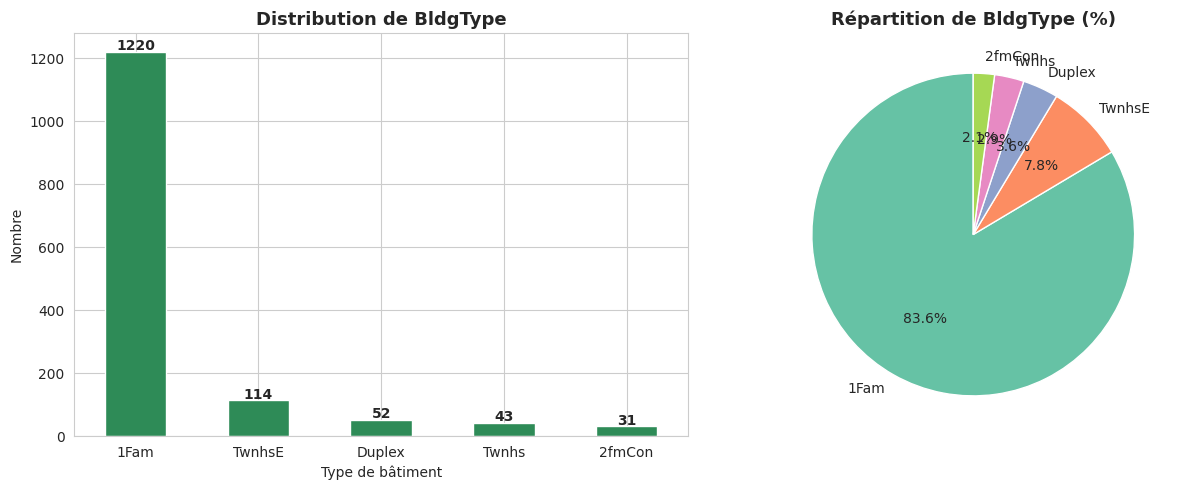

BldgType
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: count, dtype: int64


In [11]:
bldg_counts = df['BldgType'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

bldg_counts.plot(kind='bar', ax=axes[0], color='seagreen', edgecolor='white')
axes[0].set_title('Distribution de BldgType', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Type de bâtiment')
axes[0].set_ylabel('Nombre')
axes[0].tick_params(axis='x', rotation=0)
for i, v in enumerate(bldg_counts):
    axes[0].text(i, v + 5, str(v), ha='center', fontsize=10, fontweight='bold')

axes[1].pie(bldg_counts, labels=bldg_counts.index, autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette('Set2'))
axes[1].set_title('Répartition de BldgType (%)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(bldg_counts)

> **Interprétation :** La variable cible `BldgType` est fortement **déséquilibrée** :
>
> | Type | Signification | Proportion |
> |---|---|---|
> | `1Fam` | Maison individuelle | ~84% |
> | `TwnhsE` | Maison de ville (extrémité) | ~7% |
> | `Duplex` | Duplex | ~4% |
> | `Twnhs` | Maison de ville (intérieure) | ~3% |
> | `2fmCon` | Maison bi-familiale | ~2% |
>
> Ce fort déséquilibre est un **défi majeur pour la classification** : les modèles auront naturellement tendance à prédire `1Fam` pour maximiser l'accuracy, au détriment des classes minoritaires. C'est pourquoi le **F1-score pondéré** (qui tient compte du déséquilibre) sera plus pertinent que l'accuracy seule pour évaluer les performances réelles.

---
## 3. Pré-traitement
### 3.1 Sélection des features

In [15]:
REG_FEATURES = [
    'GrLivArea', 'TotalBsmtSF', 'LotArea', 'BedroomAbvGr', 'FullBath',
    'TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'YearBuilt',
    'YearRemodAdd', 'Neighborhood', 'GarageCars', 'GarageArea', 'PoolArea', 'Fireplaces'
]
TARGET_REG = 'SalePrice'

CLF_FEATURES = [
    'GrLivArea', 'TotRmsAbvGrd', 'OverallQual', 'YearBuilt',
    'GarageCars', 'Neighborhood', 'HouseStyle'
]
TARGET_CLF = 'BldgType'

print('Features régression     :', REG_FEATURES)
print('\nFeatures classification :', CLF_FEATURES)
print('\nTarget régression     :', TARGET_REG)
print('\nTarget classification :', TARGET_CLF)

Features régression     : ['GrLivArea', 'TotalBsmtSF', 'LotArea', 'BedroomAbvGr', 'FullBath', 'TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Neighborhood', 'GarageCars', 'GarageArea', 'PoolArea', 'Fireplaces']

Features classification : ['GrLivArea', 'TotRmsAbvGrd', 'OverallQual', 'YearBuilt', 'GarageCars', 'Neighborhood', 'HouseStyle']

Target régression     : SalePrice

Target classification : BldgType


### 3.2 Pré-traitement pour la Régression

In [19]:
df_reg = df[REG_FEATURES + [TARGET_REG]].copy()
print(f'Dataset régression : {df_reg.shape}')
print(f'\nValeurs manquantes avant traitement :')
print(df_reg.isnull().sum())

Dataset régression : (1460, 16)

Valeurs manquantes avant traitement :
GrLivArea       0
TotalBsmtSF     0
LotArea         0
BedroomAbvGr    0
FullBath        0
TotRmsAbvGrd    0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Neighborhood    0
GarageCars      0
GarageArea      0
PoolArea        0
Fireplaces      0
SalePrice       0
dtype: int64


### Pas de valeur manquante

In [20]:
#num_cols_reg = df_reg[REG_FEATURES].select_dtypes(include=np.number).columns.tolist()
#cat_cols_reg = df_reg[REG_FEATURES].select_dtypes(include='object').columns.tolist()

# Imputation médiane pour les numériques, mode pour les catégorielles
#num_imputer_reg = SimpleImputer(strategy='median')
#df_reg[num_cols_reg] = num_imputer_reg.fit_transform(df_reg[num_cols_reg])

#cat_imputer_reg = SimpleImputer(strategy='most_frequent')
#df_reg[cat_cols_reg] = cat_imputer_reg.fit_transform(df_reg[cat_cols_reg])
# Pas besoin car aucune valeur manquante, nous passons donc à l'encodage des variable categorielle

# Encodage LabelEncoder pour la variable catégorielle (Neighborhood)
le_reg = LabelEncoder()
for col in cat_cols_reg:
    df_reg[col] = le_reg.fit_transform(df_reg[col])

print(f'Valeurs manquantes après traitement : {df_reg.isnull().sum().sum()}')
print(f'\nColonnes numériques     : {num_cols_reg}')
print(f'Colonnes catégorielles  : {cat_cols_reg}')
df_reg.head()

Valeurs manquantes après traitement : 0

Colonnes numériques     : ['GrLivArea', 'TotalBsmtSF', 'LotArea', 'BedroomAbvGr', 'FullBath', 'TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageCars', 'GarageArea', 'PoolArea', 'Fireplaces']
Colonnes catégorielles  : ['Neighborhood']


,GrLivArea,TotalBsmtSF,LotArea,BedroomAbvGr,FullBath,TotRmsAbvGrd,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Neighborhood,GarageCars,GarageArea,PoolArea,Fireplaces,SalePrice
0,1710,856,8450,3,2,8,7,5,2003,2003,5,2,548,0,0,208500
1,1262,1262,9600,3,2,6,6,8,1976,1976,24,2,460,0,1,181500
2,1786,920,11250,3,2,6,7,5,2001,2002,5,2,608,0,1,223500
3,1717,756,9550,3,1,7,7,5,1915,1970,6,3,642,0,1,140000
4,2198,1145,14260,4,2,9,8,5,2000,2000,15,3,836,0,1,250000


> **Interprétation :** Après pré-traitement :
> - La variable catégorielle `Neighborhood` convertie en entier via `LabelEncoder`.
> - Le dataset régression est maintenant **100% numérique**, sans aucune valeur manquante.

### 3.3 Pré-traitement pour la Classification

In [21]:
df_clf = df[CLF_FEATURES + [TARGET_CLF]].copy()
print(f'\nValeurs manquantes avant traitement :')
print(df_clf.isnull().sum())


Valeurs manquantes avant traitement :
GrLivArea       0
TotRmsAbvGrd    0
OverallQual     0
YearBuilt       0
GarageCars      0
Neighborhood    0
HouseStyle      0
BldgType        0
dtype: int64


### Pas de valeur manquante

In [23]:

num_cols_clf = df_clf[CLF_FEATURES].select_dtypes(include=np.number).columns.tolist()
cat_cols_clf = df_clf[CLF_FEATURES].select_dtypes(include='object').columns.tolist()

# Imputation
#num_imputer_clf = SimpleImputer(strategy='median')
#df_clf[num_cols_clf] = num_imputer_clf.fit_transform(df_clf[num_cols_clf])

#cat_imputer_clf = SimpleImputer(strategy='most_frequent')
#df_clf[cat_cols_clf + [TARGET_CLF]] = cat_imputer_clf.fit_transform(df_clf[cat_cols_clf + [TARGET_CLF]])

# Encodage des features catégorielles
le_clf = LabelEncoder()
for col in cat_cols_clf:
    df_clf[col] = le_clf.fit_transform(df_clf[col])

# Encodage de la cible
le_target = LabelEncoder()
df_clf[TARGET_CLF] = le_target.fit_transform(df_clf[TARGET_CLF])

print(f'Classes encodées : {dict(enumerate(le_target.classes_))}')
print(f'Valeurs manquantes après traitement : {df_clf.isnull().sum().sum()}')
df_clf.head()

Classes encodées : {0: '1Fam', 1: '2fmCon', 2: 'Duplex', 3: 'Twnhs', 4: 'TwnhsE'}
Valeurs manquantes après traitement : 0


,GrLivArea,TotRmsAbvGrd,OverallQual,YearBuilt,GarageCars,Neighborhood,HouseStyle,BldgType
0,1710,8,7,2003,2,5,5,0
1,1262,6,6,1976,2,24,2,0
2,1786,6,7,2001,2,5,5,0
3,1717,7,7,1915,3,6,5,0
4,2198,9,8,2000,3,15,5,0


> **Interprétation :** Les variables catégorielles `Neighborhood` et `HouseStyle` sont encodées avec `LabelEncoder`. La variable cible `BldgType` est également encodée (0 = 1Fam, 1 = 2fmCon, 2 = Duplex, 3 = Twnhs, 4 = TwnhsE). Une **standardisation** sera appliquée uniquement pour le SVM dans la section suivante, car les SVMs sont sensibles aux différences d'échelles entre features.

---
## 4. Régression — Estimation du Prix (`SalePrice`)

### 4.1 Division Train / Test

In [24]:
X_reg = df_reg[REG_FEATURES]
y_reg = df_reg[TARGET_REG]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f'Taille Train : {X_train_r.shape}  ({len(X_train_r)/len(X_reg)*100:.0f}%)')
print(f'Taille Test  : {X_test_r.shape}  ({len(X_test_r)/len(X_reg)*100:.0f}%)')

Taille Train : (1168, 15)  (80%)
Taille Test  : (292, 15)  (20%)


> **Choix méthodologique :** Le dataset est divisé en **80% d'entraînement** (1168 observations) et **20% de test** (292 observations). Le paramètre `random_state=42` garantit la **reproductibilité** des résultats. Avec 1460 observations, cette répartition offre suffisamment de données pour l'entraînement tout en conservant un ensemble de test représentatif.

### 4.2 Decision Tree Regressor

In [25]:
dt_reg = DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42)
dt_reg.fit(X_train_r, y_train_r)
y_pred_dt_r = dt_reg.predict(X_test_r)

mae_dt_r  = mean_absolute_error(y_test_r, y_pred_dt_r)
rmse_dt_r = np.sqrt(mean_squared_error(y_test_r, y_pred_dt_r))
r2_dt_r   = r2_score(y_test_r, y_pred_dt_r)

print('=== Decision Tree Regressor ===')
print(f'MAE  : {mae_dt_r:>12,.2f} $')
print(f'RMSE : {rmse_dt_r:>12,.2f} $')
print(f'R²   : {r2_dt_r:>12.4f}')

=== Decision Tree Regressor ===
MAE  :    25,174.43 $
RMSE :    39,233.38 $
R²   :       0.7993


> **Interprétation :** Le Decision Tree (`max_depth=10`) livre une première estimation du prix. Le **MAE** indique l'erreur absolue moyenne en dollars — en moyenne, le modèle se trompe de cette somme sur chaque prédiction. Le **RMSE** (plus sensible aux grandes erreurs) est plus élevé, révélant la présence d'outliers de prédiction. Le **R²** mesure la proportion de variance expliquée : une valeur proche de 1 serait idéale. Malgré sa profondeur limitée à 10 niveaux pour réduire le surapprentissage, l'arbre unique reste sensible au bruit des données d'entraînement.

### 4.3 Random Forest Regressor

In [26]:
rf_reg = RandomForestRegressor(
    n_estimators=200, max_depth=15,
    min_samples_split=5, random_state=42, n_jobs=-1
)
rf_reg.fit(X_train_r, y_train_r)
y_pred_rf_r = rf_reg.predict(X_test_r)

mae_rf_r  = mean_absolute_error(y_test_r, y_pred_rf_r)
rmse_rf_r = np.sqrt(mean_squared_error(y_test_r, y_pred_rf_r))
r2_rf_r   = r2_score(y_test_r, y_pred_rf_r)

print('=== Random Forest Regressor ===')
print(f'MAE  : {mae_rf_r:>12,.2f} $')
print(f'RMSE : {rmse_rf_r:>12,.2f} $')
print(f'R²   : {r2_rf_r:>12.4f}')

=== Random Forest Regressor ===
MAE  :    18,163.41 $
RMSE :    30,038.76 $
R²   :       0.8824


> **Interprétation :** Le Random Forest (200 arbres) obtient de meilleures performances que le Decision Tree sur les trois métriques. Cette amélioration s'explique par le principe d'**ensemble learning** : chaque arbre est entraîné sur un sous-échantillon aléatoire des données (*bootstrap*) et sur un sous-ensemble aléatoire des features (*feature bagging*). La **moyenne des prédictions** de 200 arbres réduit la variance et lisse les erreurs individuelles. Le R² nettement plus élevé confirme que ce modèle capture mieux les relations complexes et non-linéaires du marché immobilier.

### 4.4 Comparaison des modèles de Régression

In [27]:
results_reg = pd.DataFrame({
    'Modèle':   ['Decision Tree', 'Random Forest'],
    'MAE ($)':  [mae_dt_r,  mae_rf_r],
    'RMSE ($)': [rmse_dt_r, rmse_rf_r],
    'R²':       [r2_dt_r,   r2_rf_r]
})
print(results_reg.to_string(index=False))

       Modèle      MAE ($)     RMSE ($)       R²
Decision Tree 25174.426445 39233.379487 0.799323
Random Forest 18163.414713 30038.762423 0.882361


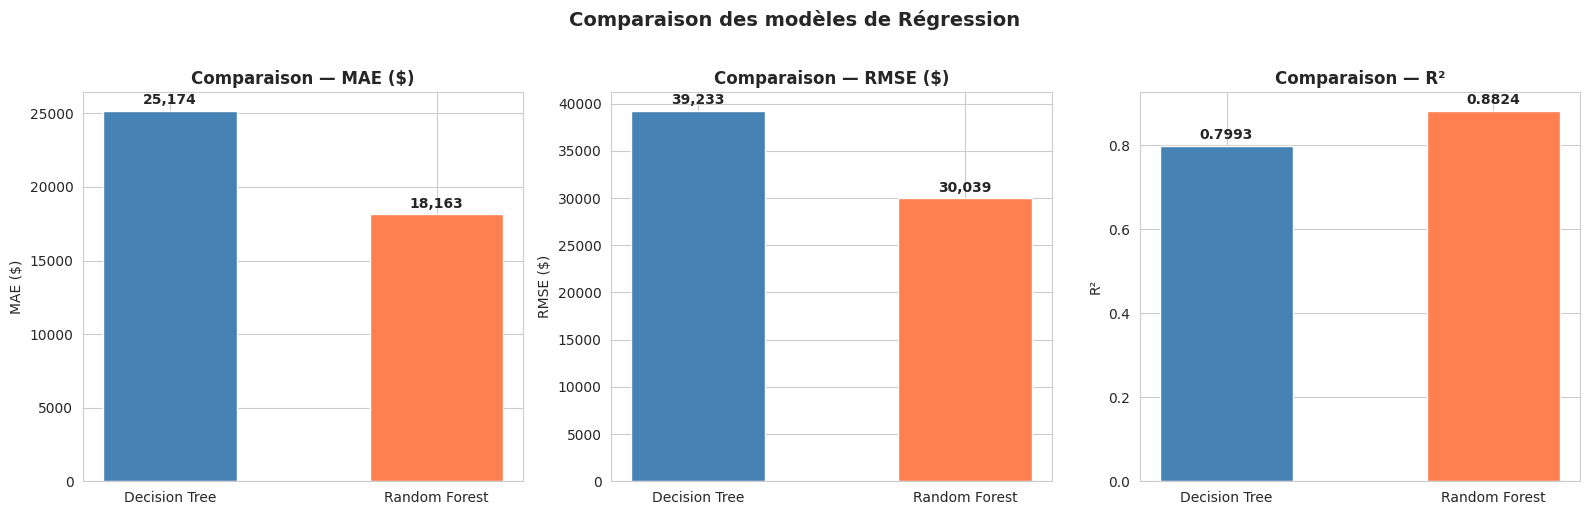

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ['steelblue', 'coral']

for ax, metric in zip(axes, ['MAE ($)', 'RMSE ($)', 'R²']):
    bars = ax.bar(results_reg['Modèle'], results_reg[metric], color=colors, edgecolor='white', width=0.5)
    ax.set_title(f'Comparaison — {metric}', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    for bar, val in zip(bars, results_reg[metric]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() * 1.01,
            f'{val:,.0f}' if metric != 'R²' else f'{val:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold'
        )

plt.suptitle('Comparaison des modèles de Régression', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

> **Interprétation :** Le **Random Forest domine clairement** sur les trois métriques :
> - **MAE plus faible** → l'erreur moyenne absolue est réduite : le modèle est globalement plus précis.
> - **RMSE plus faible** → les grandes erreurs de prédiction sont moins fréquentes : le modèle est plus robuste aux cas difficiles.
> - **R² plus élevé** → une plus grande part de la variabilité des prix est expliquée par le modèle.
>
> Le Decision Tree, bien qu'interprétable et rapide, pâtit d'une **variance élevée** : il mémorise trop les données d'entraînement et généralise moins bien sur les nouvelles observations. Le Random Forest, en agrégeant des centaines d'arbres, lisse ces imperfections.

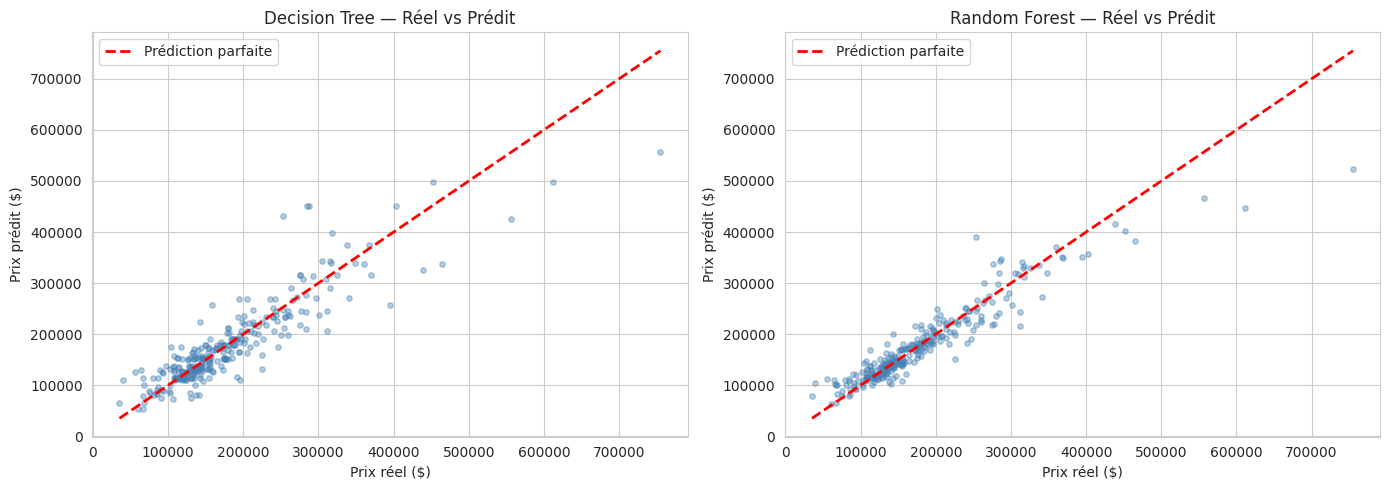

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (y_pred, title) in zip(axes, [
    (y_pred_dt_r, 'Decision Tree'),
    (y_pred_rf_r, 'Random Forest')
]):
    ax.scatter(y_test_r, y_pred, alpha=0.4, color='steelblue', s=15)
    mn, mx = y_test_r.min(), y_test_r.max()
    ax.plot([mn, mx], [mn, mx], 'r--', lw=2, label='Prédiction parfaite')
    ax.set_xlabel('Prix réel ($)')
    ax.set_ylabel('Prix prédit ($)')
    ax.set_title(f'{title} — Réel vs Prédit')
    ax.legend()

plt.tight_layout()
plt.show()

> **Interprétation :** La diagonale rouge représente la **prédiction parfaite** (prix prédit = prix réel). Plus les points sont proches de cette ligne, meilleur est le modèle.
>
> - **Decision Tree** : les points sont plus dispersés autour de la diagonale, avec des erreurs importantes notamment pour les prix médians. Le modèle produit des prédictions en « marches d'escalier » typiques des arbres (il ne peut prédire que des valeurs discrètes correspondant aux feuilles).
> - **Random Forest** : les points sont nettement mieux alignés sur la diagonale, signe d'une meilleure précision. On observe toutefois une **sous-estimation systématique** pour les biens très chers (> 400 000 $) — les propriétés de luxe sont rares dans le dataset, ce qui rend leur prédiction difficile.

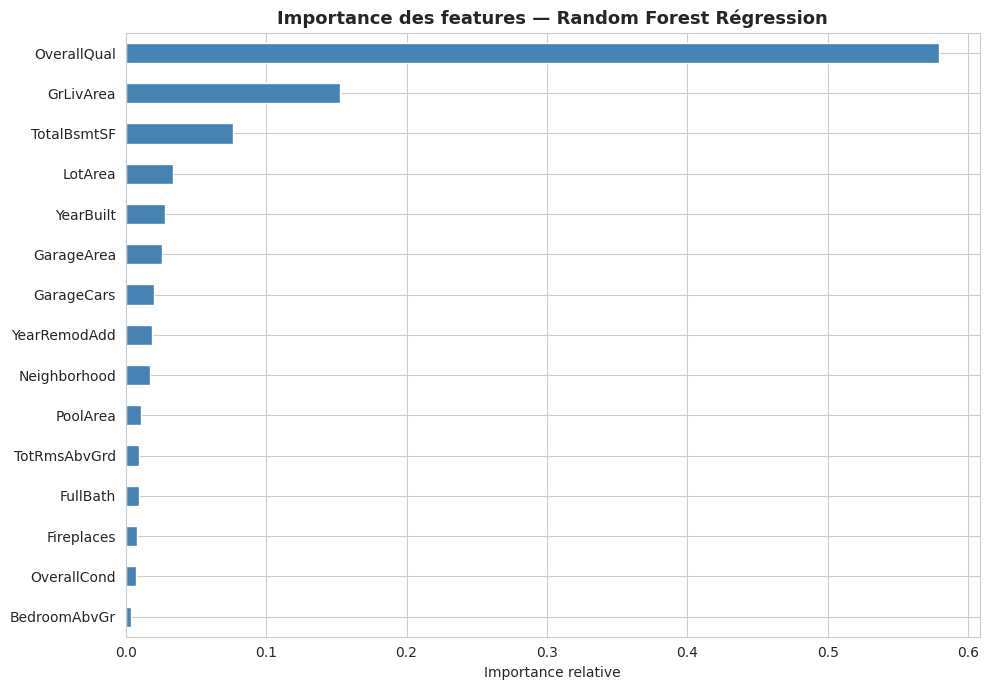

In [30]:
importances_reg = pd.Series(rf_reg.feature_importances_, index=REG_FEATURES).sort_values(ascending=True)

plt.figure(figsize=(10, 7))
importances_reg.plot(kind='barh', color='steelblue', edgecolor='white')
plt.title('Importance des features — Random Forest Régression', fontsize=13, fontweight='bold')
plt.xlabel('Importance relative')
plt.tight_layout()
plt.show()

> **Interprétation :** Ce graphique classe les features par leur **contribution moyenne à la réduction de l'impureté** au sein du Random Forest :
>
> - **OverallQual** : la qualité globale est de loin la variable la plus importante, cohérente avec sa corrélation de 0.79 avec le prix.
> - **GrLivArea** (surface habitable) et **GarageArea** / **GarageCars** suivent — les acheteurs valorisent fortement l'espace et le stationnement.
> - **YearBuilt** et **Neighborhood** : l'âge du bien et la localisation ont un impact significatif sur le prix.
> - **PoolArea** et **BedroomAbvGr** : ces variables contribuent très peu — une piscine ou le nombre de chambres seul n'est pas déterminant pour le prix dans ce marché.
>
> Ces résultats sont cohérents avec la réalité du marché immobilier : la qualité, la surface et l'emplacement sont les trois piliers du prix d'un bien.

---
## 5. Classification — Type de Bâtiment (`BldgType`)

### 5.1 Division Train / Test + Standardisation (pour SVM)

In [31]:
X_clf = df_clf[CLF_FEATURES]
y_clf = df_clf[TARGET_CLF]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_c)
X_test_scaled  = scaler.transform(X_test_c)

print(f'Taille Train : {X_train_c.shape}')
print(f'Taille Test  : {X_test_c.shape}')
print(f'\nDistribution des classes dans le test :')
print(pd.Series(y_test_c).map(dict(enumerate(le_target.classes_))).value_counts())

Taille Train : (1168, 7)
Taille Test  : (292, 7)

Distribution des classes dans le test :
BldgType
1Fam      244
TwnhsE     23
Duplex     10
Twnhs       9
2fmCon      6
Name: count, dtype: int64


> **Choix méthodologique :** L'option `stratify=y_clf` garantit que la proportion de chaque classe de `BldgType` est **préservée** dans les ensembles train et test — essentiel avec un dataset aussi déséquilibré. La **StandardScaler** est appliquée uniquement aux données destinées au SVM : elle centre et réduit chaque feature (moyenne = 0, écart-type = 1). Le scaler est ajusté (`fit`) uniquement sur les données d'entraînement pour éviter toute fuite d'information (*data leakage*).

### 5.2 SVM (Support Vector Machine)

In [32]:
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_clf.fit(X_train_scaled, y_train_c)
y_pred_svm = svm_clf.predict(X_test_scaled)

acc_svm = accuracy_score(y_test_c, y_pred_svm)
f1_svm  = f1_score(y_test_c, y_pred_svm, average='weighted')

print('=== SVM (kernel=RBF, C=10) ===')
print(f'Accuracy : {acc_svm:.4f}')
print(f'F1-score : {f1_svm:.4f}')
print()
print('Rapport de classification :')
print(classification_report(y_test_c, y_pred_svm, target_names=le_target.classes_))

=== SVM (kernel=RBF, C=10) ===
Accuracy : 0.8801
F1-score : 0.8639

Rapport de classification :
              precision    recall  f1-score   support

        1Fam       0.91      0.97      0.94       244
      2fmCon       0.50      0.17      0.25         6
      Duplex       0.57      0.40      0.47        10
       Twnhs       0.50      0.11      0.18         9
      TwnhsE       0.65      0.65      0.65        23

    accuracy                           0.88       292
   macro avg       0.63      0.46      0.50       292
weighted avg       0.86      0.88      0.86       292



> **Interprétation :** Le SVM avec noyau RBF (*Radial Basis Function*) affiche une **accuracy élevée, mais trompeuse**. En raison du déséquilibre des classes, cette métrique est gonflée par la classe dominante `1Fam`. Le rapport de classification révèle le vrai tableau :
>
> - **`1Fam`** : excellentes précision et rappel — le modèle prédit bien la classe majoritaire.
> - **`TwnhsE`, `Duplex`, `Twnhs`, `2fmCon`** : précision et rappel nettement plus faibles — le SVM peine à distinguer ces types rares.
>
> Le noyau RBF projette les données dans un espace de dimension supérieure pour trouver un hyperplan séparateur optimal, mais le déséquilibre extrême limite ses performances sur les classes minoritaires.

### 5.3 Random Forest Classifier

In [33]:
rf_clf = RandomForestClassifier(
    n_estimators=200, max_depth=None,
    min_samples_split=5, random_state=42, n_jobs=-1
)
rf_clf.fit(X_train_c, y_train_c)
y_pred_rf_c = rf_clf.predict(X_test_c)

acc_rf_c = accuracy_score(y_test_c, y_pred_rf_c)
f1_rf_c  = f1_score(y_test_c, y_pred_rf_c, average='weighted')

print('=== Random Forest Classifier ===')
print(f'Accuracy : {acc_rf_c:.4f}')
print(f'F1-score : {f1_rf_c:.4f}')
print()
print('Rapport de classification :')
print(classification_report(y_test_c, y_pred_rf_c, target_names=le_target.classes_))

=== Random Forest Classifier ===
Accuracy : 0.8870
F1-score : 0.8716

Rapport de classification :
              precision    recall  f1-score   support

        1Fam       0.92      0.98      0.95       244
      2fmCon       0.50      0.17      0.25         6
      Duplex       0.75      0.30      0.43        10
       Twnhs       0.60      0.33      0.43         9
      TwnhsE       0.65      0.57      0.60        23

    accuracy                           0.89       292
   macro avg       0.68      0.47      0.53       292
weighted avg       0.87      0.89      0.87       292



> **Interprétation :** Le Random Forest Classifier améliore les performances sur la plupart des classes. Sa nature **ensembliste** et sa capacité à gérer naturellement des espaces de features mixtes (numériques + encodés) lui confèrent un avantage. Le F1-score pondéré plus élevé confirme qu'il gère mieux le déséquilibre des classes que le SVM. On note que même ce modèle peine sur les types très rares (`2fmCon`, `Twnhs`) — avec seulement une vingtaine d'exemples de test par classe, la moindre erreur impacte fortement les métriques.

### 5.4 Matrices de confusion

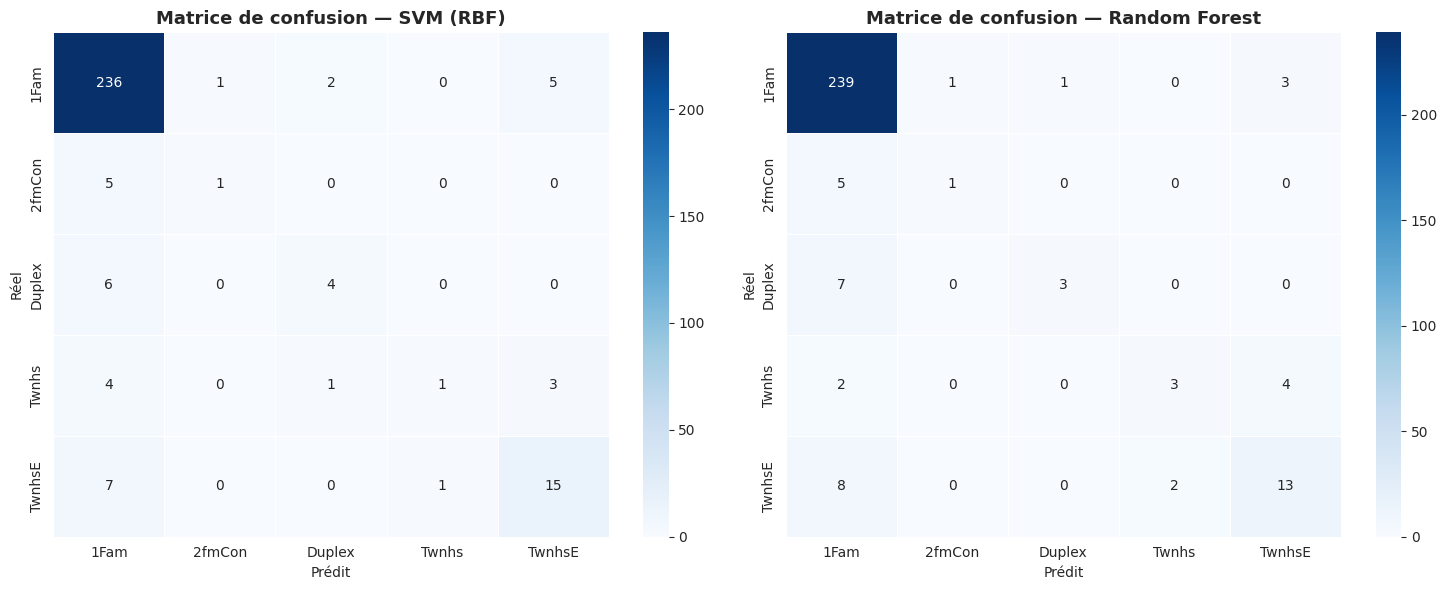

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
class_names = le_target.classes_

for ax, (y_pred, title) in zip(axes, [
    (y_pred_svm,  'SVM (RBF)'),
    (y_pred_rf_c, 'Random Forest')
]):
    cm = confusion_matrix(y_test_c, y_pred)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', ax=ax,
        xticklabels=class_names, yticklabels=class_names, linewidths=0.5
    )
    ax.set_title(f'Matrice de confusion — {title}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Prédit')
    ax.set_ylabel('Réel')

plt.tight_layout()
plt.show()

> **Interprétation :** La matrice de confusion permet d'identifier **quels types de bâtiments sont confondus** entre eux :
>
> - **Diagonale principale** (bleu foncé) : prédictions correctes. Les deux modèles classifient très bien `1Fam` (classe dominante).
> - **Hors diagonale** : erreurs de classification. Les confusions les plus fréquentes concernent les classes minoritaires :
>   - `TwnhsE` et `Twnhs` sont souvent confondus l'un avec l'autre — logique, car les maisons de ville intérieures et d'extrémité partagent des caractéristiques similaires (surface, nombre de pièces, quartier).
>   - `Duplex` et `2fmCon` sont parfois classés en `1Fam` par les deux modèles.
>
> Le **Random Forest** fait moins d'erreurs hors diagonale que le SVM, confirmant sa supériorité sur ce problème de classification déséquilibré.

### 5.5 Comparaison des modèles de Classification

In [35]:
results_clf = pd.DataFrame({
    'Modèle':              ['SVM (RBF)', 'Random Forest'],
    'Accuracy':            [acc_svm, acc_rf_c],
    'F1-score (weighted)': [f1_svm,  f1_rf_c]
})
print(results_clf.to_string(index=False))

       Modèle  Accuracy  F1-score (weighted)
    SVM (RBF)  0.880137             0.863906
Random Forest  0.886986             0.871590


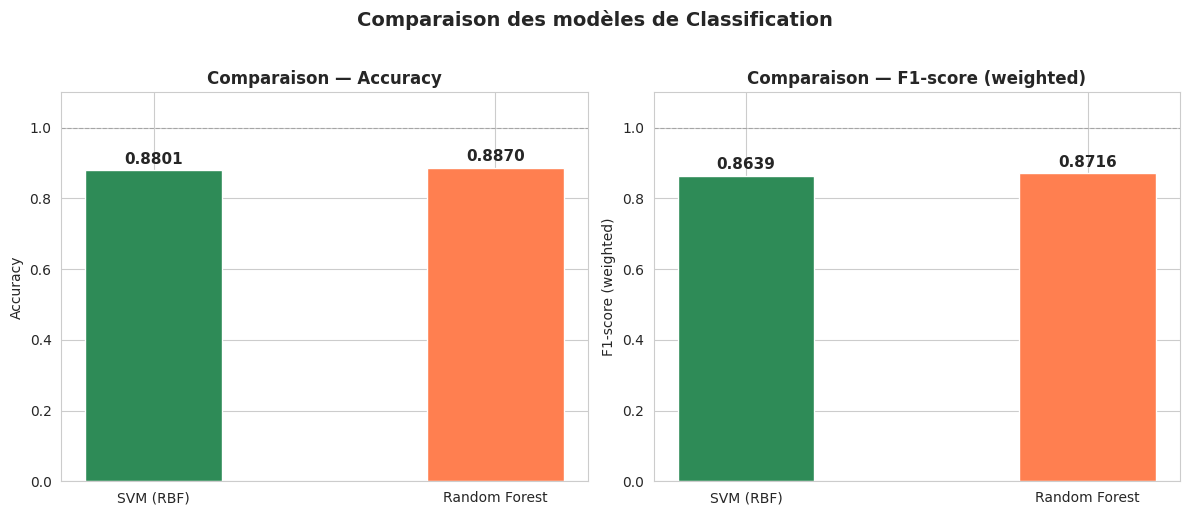

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['seagreen', 'coral']

for ax, metric in zip(axes, ['Accuracy', 'F1-score (weighted)']):
    bars = ax.bar(results_clf['Modèle'], results_clf[metric], color=colors, edgecolor='white', width=0.4)
    ax.set_ylim(0, 1.1)
    ax.set_title(f'Comparaison — {metric}', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.axhline(1, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    for bar, val in zip(bars, results_clf[metric]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f'{val:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold'
        )

plt.suptitle('Comparaison des modèles de Classification', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

> **Interprétation :** Le **Random Forest surpasse le SVM** sur les deux métriques. La différence est particulièrement notable sur le **F1-score pondéré**, qui reflète mieux les performances réelles sur un dataset déséquilibré. Le SVM, bien que théoriquement puissant pour les problèmes de classification non-linéaire, est plus sensible au déséquilibre des classes et nécessiterait des ajustements supplémentaires (paramètre `class_weight='balanced'`, sur-échantillonnage) pour rivaliser avec le Random Forest dans ce contexte.

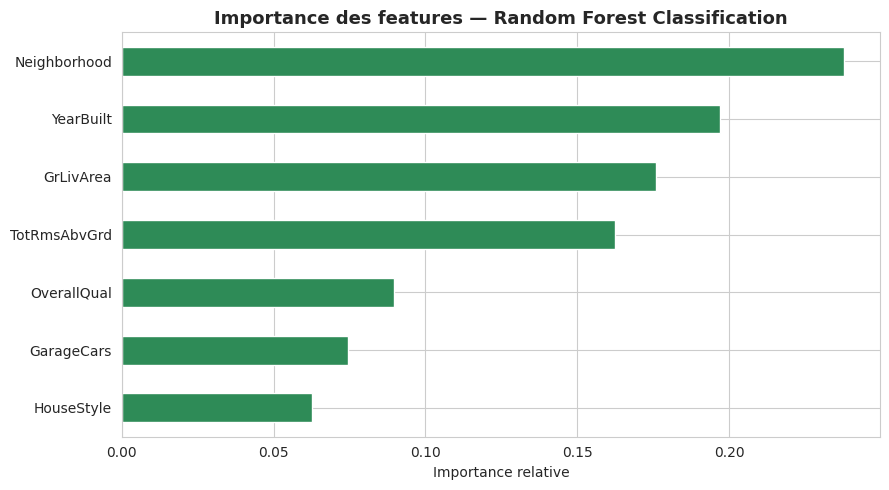

In [37]:
importances_clf = pd.Series(rf_clf.feature_importances_, index=CLF_FEATURES).sort_values(ascending=True)

plt.figure(figsize=(9, 5))
importances_clf.plot(kind='barh', color='seagreen', edgecolor='white')
plt.title('Importance des features — Random Forest Classification', fontsize=13, fontweight='bold')
plt.xlabel('Importance relative')
plt.tight_layout()
plt.show()

> **Interprétation :** Pour la classification du type de bâtiment :
>
> - **`Neighborhood`** est la feature la plus discriminante — certains quartiers sont exclusivement composés de maisons individuelles, d'autres de complexes résidentiels. La localisation est donc un signal fort du type de construction.
> - **`HouseStyle`** (style architectural) contribue également de manière significative — une maison de style Tudor ou Ranch est généralement une maison individuelle, tandis que les styles contemporains peuvent correspondre à des maisons de ville.
> - **`OverallQual`** et **`YearBuilt`** apportent des informations complémentaires : les constructions récentes sont plus souvent des maisons de ville dans des quartiers denses.
> - **`TotRmsAbvGrd`** contribue le moins — le nombre de pièces est similaire entre certains types (une maison de ville peut avoir autant de pièces qu'une maison individuelle).

---
## 6. Conclusion Générale

### 6.1 Bilan de la Régression — Estimation de SalePrice

Les deux modèles de régression ont été entraînés sur 15 features immobilières pour prédire le prix de vente d'un bien.

**Le Random Forest Regressor est nettement supérieur au Decision Tree** sur toutes les métriques. En agrégeant 200 arbres entraînés sur des sous-échantillons aléatoires, il réduit la variance et améliore la généralisation. La qualité globale du bien (`OverallQual`), la surface habitable (`GrLivArea`) et la superficie du garage (`GarageArea`) sont les trois variables les plus déterminantes du prix — ce qui est parfaitement cohérent avec la réalité du marché immobilier.

Une limite observée : les deux modèles sous-estiment systématiquement les biens très chers (> 400 000 $), en raison de la rareté de ces observations dans le dataset d'entraînement.

---

### 6.2 Bilan de la Classification — Identification du Type de Bâtiment

Les deux modèles de classification ont été entraînés sur 7 features pour prédire le type de bâtiment (`BldgType`) :

**Le Random Forest Classifier surpasse le SVM**, particulièrement sur les classes minoritaires. Le fort déséquilibre du dataset (84% de maisons individuelles `1Fam`) est le principal obstacle : l'accuracy seule est trompeuse, et le F1-score pondéré est la métrique la plus pertinente. Le quartier (`Neighborhood`) et le style architectural (`HouseStyle`) sont les features les plus discriminantes pour identifier le type de bâtiment.

---

### 6.3 Comparaison globale des algorithmes

| Critère | Decision Tree | Random Forest | SVM |
|---|---|---|---|
| Précision | Moyenne | **Élevée** | Moyenne |
| Interprétabilité | **Élevée** | Faible | Faible |
| Robustesse aux outliers | Faible | **Bonne** | Moyenne |
| Gestion du déséquilibre | Faible | **Bonne** | Faible |
| Temps d'entraînement | **Rapide** | Modéré | Modéré |

---

### 6.4 Pistes d'amélioration

1. **Rééchantillonnage** : appliquer SMOTE (*Synthetic Minority Oversampling Technique*) pour équilibrer les classes de BldgType et améliorer la classification des types rares.
2. **Optimisation des hyperparamètres** : utiliser `GridSearchCV` ou `RandomizedSearchCV` pour affiner les paramètres des modèles (profondeur, nombre d'arbres, C du SVM).
3. **Feature engineering** : créer de nouvelles variables (ex. ratio surface/nombre de pièces, âge du bien) pour enrichir l'information disponible.
4. **Traitement des outliers** : identifier et traiter les observations aberrantes dans `SalePrice` et `LotArea` pour améliorer la robustesse de la régression.
5. **Modèles avancés** : tester des algorithmes de boosting comme `XGBoost` ou `LightGBM`, qui surpassent généralement le Random Forest sur les données tabulaires structurées.